# Run Cellpose 2.0 for IPQDA assignment 8 using Colab with GPU

Author: Catherine Chia

Date: 2022-06-20

Real authors: Carsen Stringer, Marius Pachitariu, Pradeep Rajasekhar, Jacquemet lab, and Henriques lab. 

References:
https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb

https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/Cellpose_cell_segmentation_2D_prediction_only.ipynb

https://cellpose.readthedocs.io/en/latest/


## Setup

In [1]:
#Setup
!pip install cellpose
!pip install torch torchvision torchaudio #from2D
!pip install "opencv-python-headless<4.3"

#Other libraries
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from urllib.parse import urlparse
import shutil

#GPU 
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')


#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

#from tifffile import imread, imsave

#https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 168 kB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 63.7 MB/s 
     |████████████████████████████████| 3.5 MB 43.2 MB/s 
     |████████████████████████████████| 31.0 MB 101.9 MB/s 
     |████████████████████████████████| 48.3 MB 62 kB/s 
     |████████████████████████████████| 34.5 MB 19 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21

## Images to segment

In [2]:
#@markdown ###Step 4: Enter Directory path containing the image(s): 
#@markdown ##### Existing Masks directory will be deleted. (Does not read images in subfolders)
Input_Directory = "/content/gdrive/MyDrive/_Shared/20220617_IPQDA_A8/data/perHyperstack" #@param {type:"string"}
dir = Input_Directory #TODO: To remove
input_dir = os.path.join(Input_Directory, "") #adds separator to the end regardless if path has it or not

#@markdown ###Optional: Enter image extension here to read only files/images of specified extension (.tif,.jpg..): 
#@markdown ###### Leave empty if not specifying anything
image_format = "tif" #@param {type:"string"}

##@markdown ###Tick if image is RGB: 
#RGB= False #@param {type:"boolean"}
#rgb=RGB
save_dir = input_dir+"Masks/"
if not os.path.exists(save_dir):
  os.makedirs(save_dir)
else:
  print("Existing Mask Directory found. Deleting it.")
  shutil.rmtree(save_dir)

#@markdown ##### Save Directory will be created in the input path under Masks

##@markdown ###Advanced Parameters
#Use_Default_Advanced_Parameters = True #@param {type:"boolean"}


# r=root, d=directories, f = files
files=[] #store all files

for r, d, f in os.walk(input_dir):
    for fil in f:
      if (image_format):
        if fil.endswith(image_format):
          files.append(os.path.join(r, fil))
      else:
        files.append(os.path.join(r, fil))
    break #only read the root directory; can change this to include levels
if(len(files)==0):
  print("Number of images loaded: %d." %(len(files)))
  print("Cannot read image files. Check if folder has images")
else:
  print("Number of images loaded: %d." %(len(files)))




Number of images loaded: 1.


## Download pre-trained models

In [3]:
print ("Downloading Models")
from cellpose import models,core

print("*************************************************")
print("Libraries imported and configured")

*************************************************
Libraries imported and configured


## Select a model (e.g. cyto, nicknamed Cytoplasm)

In [4]:
#@markdown ###Pre-trained model:
Model_Choice = "Cytoplasm" #@param ["Cytoplasm","Cytoplasm2", "Cytoplasm2_Omnipose", "Bacteria_Omnipose", "Nuclei"]
model_choice=Model_Choice

print("Using model ",model_choice)

#@markdown ###Channel Parameters:
Channel_to_use_for_segmentation = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

#@markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:
Use_nuclear_channel= True #@param {type:"boolean"}
# Nuclear_channel="1" #@param[1,2,3]
Second_segmentation_channel= "Red" #@param ["None", "Blue", "Green", "Red"]



#########################
# Some background work
# Here we match the choice of model to its original/true label
if model_choice=="Cytoplasm":
  model_type="cyto"

elif model_choice=="Cytoplasm2":
  model_type="cyto2"

elif model_choice=="Cytoplasm2_Omnipose":
  model_type="cyto2_omni"

elif model_choice=="Bacteria_Omnipose":
  model_type="bact_omni" 
  diameter = 0

elif model_choice=="Nuclei":
  model_type="nuclei" 


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  Channel_for_segmentation = 0
elif Channel_to_use_for_segmentation == "Blue":
  Channel_for_segmentation = 3
elif Channel_to_use_for_segmentation == "Green":
  Channel_for_segmentation = 2
elif Channel_to_use_for_segmentation == "Red":
  Channel_for_segmentation = 1

segment_channel=int(Channel_for_segmentation)

if Second_segmentation_channel == "Blue":
  Nuclear_channel = 3
elif Second_segmentation_channel == "Green":
  Nuclear_channel = 2
elif Second_segmentation_channel == "Red":
  Nuclear_channel = 1
elif Second_segmentation_channel == "None":
  Nuclear_channel = 0

nuclear_channel=int(Nuclear_channel)


# #@markdown If the image has only one channel, leave it as 0
# Channel_for_segmentation="2" #@param[0,1,2,3]

# channels = [cytoplasm, nucleus]
if model_choice not in "Nuclei":
  if Use_nuclear_channel:
    channels=[segment_channel,nuclear_channel]
  else:
    channels=[segment_channel,0]
else: #nucleus
  channels=[segment_channel,0]


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
#model = models.Cellpose(gpu=use_GPU, model_type=model_type, omni = omni)
model = models.Cellpose(gpu=use_GPU, model_type=model_type)



# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]

Using model  Cytoplasm


100%|██████████| 25.3M/25.3M [00:00<00:00, 85.7MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 6.24MB/s]


## Parameters

In [7]:
#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  30 #@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
if diameter is 0:
  diameter = None
  print("Diameter is set to None. The size of the cells will be estimated on a per image basis")


#TODO: omnipose
# # @markdown ###If cells are elongated or have branches, tick this. It will use omnipose

# omni= False #@param {type:"boolean"}




## Preprocess images to a format that Cellpose is happy with.

Multiplane images should be of shape nplanes x channels x nY x nX, or 
as nplanes x nY x nX.
[https://cellpose.readthedocs.io/en/latest/inputs.html]

In [8]:
# gets image files in dir (ignoring image files ending in _masks)
imgs=[] #store all images

#Read images 
for f in files:
  im = skimage.io.imread(f)
  n_dim = len(im.shape)     #shape of image
  dim = im.shape            #dimension of image
  id_channel = min(dim)     #channel will be dimension with min value usually
  channel_position = dim.index(id_channel)

  
  # print(n_dim)
  # print(dim)
  # print(channel_position)

  #if number of dim is 3 and id_channel is first index, swap channel to last indx
  if n_dim == 3 and channel_position == 0:
    im = im.transpose (1,2,0)
    dim = im.shape
    
  
  #specifically for IPQDA A8 because the dataset is of dim = (27, 1024, 1024, 3)
  if n_dim == 4 and channel_position == 3:
    im = np.transpose(im, (0,3,1,2))

    #Update dimensions
    n_dim = len(im.shape)     #shape of image
    dim = im.shape            #dimension of image
    id_channel = min(dim)     #channel will be dimension with min value usually
    channel_position = dim.index(id_channel)

    print("Shape changed")
    print("Shape of image: " + str(n_dim))
    print("Dimension of image: " + str(dim))
    print("Channel position: " + str(channel_position))

  imgs.append(im)
  

nimg = len(imgs)
print("No of images loaded are: ", nimg)




Shape changed
Shape of image: 4
Dimension of image: (27, 3, 1024, 1024)
Channel position: 1
No of images loaded are:  1


## Run selected Cellpose model to image(s) to segment cells

Save output:
1.   *_seg.npy (segmentation in numpy array)
2.   *masks.tiff (masks)
3. Save parameters in *.txt 

In [9]:
# Loop through image list
masks=[] #stores all masks
flows=[] #stores all flows
segs =[] #stores all segs

for img_idx, img in enumerate(imgs):
    file_name=os.path.splitext(os.path.basename(files[img_idx]))[0]
    print("\nSegmenting: ",file_name)

    mask, flow, style, diam = model.eval(
        img, diameter=diameter, 
        flow_threshold=flow_threshold,
        cellprob_threshold=cellprob_threshold, 
        channels=channels,
        do_3D=True)
    
    #save images in folder with the diameter value used in cellpose
    print("Segmentation complete . Saving Masks, Flows and Segs")
    
    #SAVING MASK
    ##mask_output_name=save_dir+"MASK_"+file_name+".tif"
    mask_output_name=save_dir+file_name+"_cp_masks.tif" #corrected for IPQDA assignment 8
   
    #Save mask as 16-bit in case this has to be used for detecting than 255 objects
    mask=mask.astype(np.uint16)
    skimage.io.imsave(mask_output_name,mask, check_contrast=False)

    masks.append(mask)
    
    #SAVING FLOWS
    #flow_output_name=flows_save_dir+"FLOWS_"+file_name+".tif"
    flow_output_name=save_dir+file_name+"_cp_flows.tif"

    #Save as 8-bit
    flow_image=flow[0].astype(np.uint8)
    skimage.io.imsave(flow_output_name,flow_image, check_contrast=False)

    flows.append(flow)

    #SAVING SEGMENTATIONS
    #cellpose.io
    seg_output_name = save_dir + file_name + "_seg.npy"
    seg = io.masks_flows_to_seg(img, 
                          mask, 
                          flow, 
                          diam, 
                          seg_output_name, 
                          channels)
    segs.append(seg)


#Save parameters used in Cellpose
parameters_file=save_dir+"Cellpose_parameters_used.txt" 
outFile=open(parameters_file, "w") 
outFile.write("CELLPOSE PARAMETERS\n") 
outFile.write("Model: "+model_choice+"\n") 
if diameter == 0:
  diameter = "Automatically estimated by cellpose"
#outFile.write("Omni Flag: "+str(omni)+"\n") 
outFile.write("Diameter: "+str(diameter)+"\n") 
outFile.write("Flow Threshold: "+str(flow_threshold)+"\n") 
outFile.write("Cell probability Threshold: "+str(cellprob_threshold)+"\n") 
outFile.close() 
print("\nSegmentation complete and files saved")



Segmenting:  KTRed
Segmentation complete . Saving Masks, Flows and Segs

Segmentation complete and files saved


## Plot cellprob, gradXY and gradZ...

...nah, I give up here. 

I will install Cellpose to view the generated *_seg.npy and all other files. 

TypeError: ignored

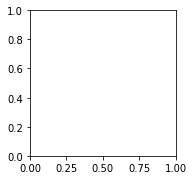

In [11]:
# # DISPLAY RESULTS
# from cellpose import plot, utils, io

# nimg = len(imgs)
# for idx in range(nimg):
#     maski = masks[idx]
#     flowi = flows[idx][0]

#     fig = plt.figure(figsize=(12,5))
#     plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
#     plt.tight_layout()
#     plt.show()



#**How to extract the ROIs from the mask or label maps using FIJI**

The masks will be saved as a 16-bit label image, where each cell/ROI is a different colour or label. If you are using ImageJ/FIJI and want to convert this to ROIs for the ROI Manager, there are a few options to convert into ROIs:


*   SCF plugin (Update site:	https://sites.imagej.net/SCF-MPI-CBG/). After [installing the plugin](https://imagej.net/How_to_follow_a_3rd_party_update_site), go to SCF-> Segmentation -> LabelMap to ROI Manager (2D). This should generate the ROIs in ROI Manager

*   Another really nice plugin: [LabelsToROIs](https://github.com/ariel-waisman/LabelsToROis). It has some nice features to adjust the size of the ROIs and generate measurements  